All code originated from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Environment

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/NYU/ML_Sundeep/project

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/NYU/ML_Sundeep/project


In [2]:
# # get training data
# !wget -P reference/ https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip reference/PennFudanPed
# !unzip reference/PennFudanPed.zip -d reference

In [3]:
# !git clone https://github.com/pytorch/vision.git
# !cd vision
# !git checkout v0.3.0

# !cp vision/references/detection/utils.py utils.py
# !cp vision/references/detection/transforms.py transforms.py
# !cp vision/references/detection/coco_eval.py coco_eval.py
# !cp vision/references/detection/engine.py engine.py
# !cp vision/references/detection/coco_utils.py coco_utils.py

In [4]:
import os
import numpy as np
import argparse
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.utils.data
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

## Parameter Setting

In [5]:
parser = {
    "root": os.getcwd(),
    "seed": 1,
    "cuda": True,
    "num_epochs": 10,
    "num_classes": 2,
    "lr": 0.005,
    "momentum": 0.9,
    "weight_decay": 0.0005,
    "print_freq": 10,
    "training_path": "reference/PennFudanPed/PNGImages",
    "testing_path": "reference/PennFudanPed/PedMasks",
    "model_path": "intermediate/segmentation.p",
}
config = argparse.Namespace(**parser)
device = torch.device('cuda') if torch.cuda.is_available() and config.cuda else torch.device('cpu')

## Dataset

In [38]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, config, transforms=None):
        self.config = config
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(config.training_path)))
        self.masks = list(sorted(os.listdir(config.testing_path)))

    def __getitem__(self, idx):
        imgs = list(sorted(os.listdir(os.path.join(self.config.root, self.config.training_path))))
        masks = list(sorted(os.listdir(os.path.join(self.config.root, self.config.testing_path))))
        img_path = os.path.join(self.config.root, self.config.training_path, imgs[idx])
        mask_path = os.path.join(self.config.root, self.config.testing_path, masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        obj_ids = np.unique(mask)[1:].reshape(-1, 1, 1)
        masks = mask == obj_ids # num bounding box * image height * image weight
        boxes = []
        for i in range(len(masks)):
            pos = np.where(masks[i])
            boxes.append([np.min(pos[1]), np.min(pos[0]), np.max(pos[1]), np.max(pos[0])]) # (xmin, ymin, xmax, ymax)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        target = {
            "boxes": boxes,
            "masks": torch.as_tensor(masks, dtype=torch.uint8),
            "labels": torch.ones((len(obj_ids),), dtype=torch.int64),
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 3]-boxes[:, 1]) * (boxes[:, 2]-boxes[:, 0]),
            "iscrowd": torch.zeros((len(obj_ids),), dtype=torch.int64),
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train: # during training, randomly flip the training images and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


In [8]:
torch.manual_seed(config.seed)
train_dataset = PennFudanDataset(config, get_transform(train=True))
val_dataset = PennFudanDataset(config, get_transform(train=True))

indices = torch.randperm(len(train_dataset)).tolist()

train_dataset = torch.utils.data.Subset(train_dataset, indices[:-50])
val_dataset = torch.utils.data.Subset(val_dataset, indices[-50:])

train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
    )
val_data_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
    )

## Get Model

In [6]:
def get_instance_segmentation_model(num_classes, hidden_layer=256):
    # fine tune the output class; original is 91, since we only need to detect the human, modify it to 2
    mdl = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = mdl.roi_heads.box_predictor.cls_score.in_features
    mdl.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = mdl.roi_heads.mask_predictor.conv5_mask.in_channels
    mdl.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return mdl

## Training

In [9]:
model = get_instance_segmentation_model(config.num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [10]:
for epoch in tqdm.tqdm_notebook(range(config.num_epochs)):
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=config.print_freq)
    lr_scheduler.step()
    evaluate(model, val_data_loader, device=device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/60]  eta: 0:02:53  lr: 0.000090  loss: 4.6415 (4.6415)  loss_classifier: 0.7949 (0.7949)  loss_box_reg: 0.3921 (0.3921)  loss_mask: 3.4276 (3.4276)  loss_objectness: 0.0213 (0.0213)  loss_rpn_box_reg: 0.0056 (0.0056)  time: 2.8922  data: 1.9038  max mem: 2302
Epoch: [0]  [10/60]  eta: 0:00:38  lr: 0.000936  loss: 1.7303 (2.2542)  loss_classifier: 0.4506 (0.4680)  loss_box_reg: 0.2963 (0.2845)  loss_mask: 1.0088 (1.4770)  loss_objectness: 0.0213 (0.0200)  loss_rpn_box_reg: 0.0040 (0.0047)  time: 0.7680  data: 0.1777  max mem: 2854
Epoch: [0]  [20/60]  eta: 0:00:26  lr: 0.001783  loss: 0.9477 (1.5314)  loss_classifier: 0.2060 (0.3268)  loss_box_reg: 0.2250 (0.2574)  loss_mask: 0.3999 (0.9174)  loss_objectness: 0.0196 (0.0222)  loss_rpn_box_reg: 0.0035 (0.0076)  time: 0.5528  data: 0.0060  max mem: 2854
Epoch: [0]  [30/60]  eta: 0:00:18  lr: 0.002629  loss: 0.6291 (1.2230)  loss_classifier: 0.1263 (0.2543)  loss_box_reg: 0.2131 (0.2504)  loss_mask: 0.2256 (0.6914)  loss_ob

## Save model & Evaluation

#### save model

In [11]:
torch.save(model.state_dict(), os.path.join(config.root, config.model_path))

#### load model

In [7]:
mdl = get_instance_segmentation_model(config.num_classes).to(device)
mdl.load_state_dict(torch.load(config.model_path))

<All keys matched successfully>

In [32]:
# !wget --output-document data/content_images/polar_bear.jpg "https://i.pinimg.com/originals/b7/7d/3c/b77d3c3d49f2039adfc898fa53f4e2e9.jpg"

--2020-12-06 23:31:53--  https://i.pinimg.com/originals/b7/7d/3c/b77d3c3d49f2039adfc898fa53f4e2e9.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.188.84, 2600:1409:12:1a9::1931, 2600:1409:12:1ad::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|151.101.188.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83665 (82K) [image/jpeg]
Saving to: ‘data/content_images/polar_bear.jpg’

data/content_images 100%[===================>]  81.70K  --.-KB/s    in 0.02s   

2020-12-06 23:31:53 (3.80 MB/s) - ‘data/content_images/polar_bear.jpg’ saved [83665/83665]



In [8]:
def test_image_loader(image_name, imsize=(1000, 800)):
    loader = transforms.Compose([
                                 transforms.Resize(imsize),
                                 transforms.ToTensor(),
                                 ])
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.squeeze(0).to(device, torch.float)


In [9]:
img_test = test_image_loader("data/content_images/polar_bear.jpg")

mdl.eval()
with torch.no_grad():
    prediction = mdl([img_test.to(device)])

ori_numpy = img_test.mul(255).permute(1, 2, 0).byte().cpu().numpy()
seg_numpy = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()

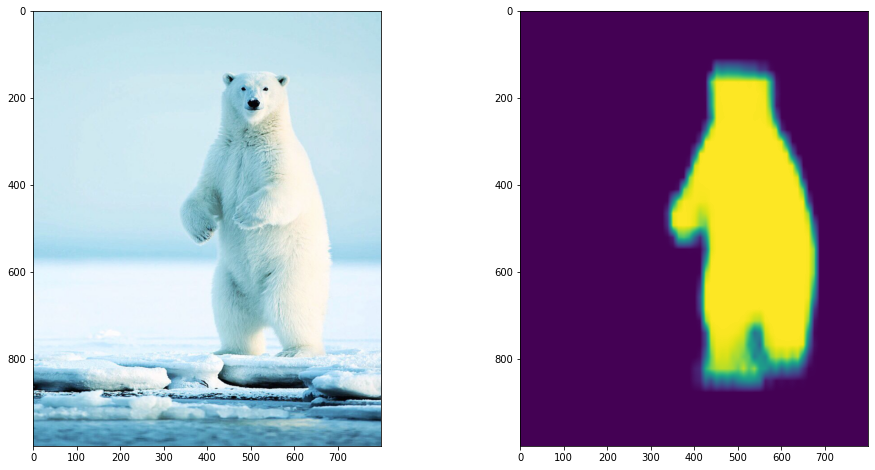

In [10]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(ori_numpy)
plt.subplot(1, 2, 2)
plt.imshow(seg_numpy)
plt.show()